In [1]:
import sys
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
import pm4py
import math

In [3]:
def read_and_clean_dataset(file_path):
    # read dataset
    data_raw = pm4py.read_xes(file_path)
        
    # Let's only consider the complete lifecycle:transition, this is because the value "complete" meaning
    # the ongoing single event task is finished instead of being suspended or withdrawal, increasing the possibility to
    # get more complete traces for our prediction
    data_raw = data_raw[data_raw['lifecycle:transition'] == 'complete']
    log = pm4py.convert_to_event_log(data_raw)
        
    # Only keep two most frequent traces, we believe these are the most complete traces
    filtered_log = pm4py.filter_end_activities(log, ['A_Pending','O_Cancelled'])
        
    df = pm4py.convert_to_dataframe(filtered_log)
    agg_dict = {"time:timestamp" :['min', 'max']}
    duration_df = pd.DataFrame(df.groupby("case:concept:name").agg(agg_dict)).reset_index()
    duration_df["trace_duration_days"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds() / (24 * 60 * 60)
    duration_df['trace_duration_days'] = duration_df['trace_duration_days'].apply(lambda x: math.ceil(x))
    duration_df["trace_duration_seconds"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds()
    duration_df.drop(columns=['time:timestamp'],inplace=True)
    duration_df = duration_df.droplevel(1, axis=1)

    df_with_duration = df.merge(duration_df, on='case:concept:name')
    #df_with_duration['sum_Time_sec'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.iloc[0]).dt.total_seconds()
    df_with_duration_remain = df_with_duration.copy()
    df_with_duration_remain['remaining_time'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.iloc[-1] - x).dt.total_seconds()
    #df_with_duration_remain['Complete_Timestamp'] = df_with_duration_remain.groupby('case:concept:name')['time:timestamp'].transform('last')
    #df_with_duration['duration'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds()
        
    return df_with_duration_remain
# Duration time, remaining_time cannot be used for testing, just for knowing data distribution

In [4]:
data = read_and_clean_dataset('BPI_Challenge_2017.xes.gz')

/Users/waterhorse/opt/anaconda3/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

/Users/waterhorse/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/waterhorse/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


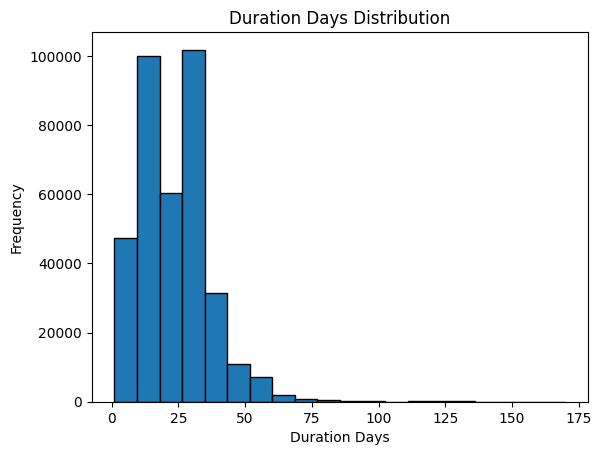

In [5]:
import matplotlib.pyplot as plt

# Assuming df_with_duration is your DataFrame containing the 'duration_days' column
# Make sure you have imported the pandas and matplotlib libraries

# Plotting the histogram
plt.hist(data['trace_duration_days'], bins=20, edgecolor='black')  # Adjust the number of bins according to your data
plt.title('Duration Days Distribution')
plt.xlabel('Duration Days')
plt.ylabel('Frequency')
plt.show()

In [6]:
quantile_25 = data['trace_duration_days'].quantile(0.25)
quantile_75 = data['trace_duration_days'].quantile(0.75)
data_iqr = data[(data['trace_duration_days'] >= quantile_25) & (data['trace_duration_days'] <= quantile_75)]

In [7]:
train_df, test_df = pm4py.split_train_test(data_iqr, train_percentage=0.75)

In [44]:
# Get prefixed with length 6,7,8,9,10
bucket_train = []
for len_prefix in [6,7,8,9,10]:
    bucket_train.append(pm4py.get_prefixes_from_log(train_df, length=len_prefix, case_id_key='case:concept:name'))

In [41]:
def AggregateTransformer(X, case_id_col, num_cols, cat_cols):
    # transform numeric cols
    if len(num_cols) > 0:
        dt_numeric = X.groupby(case_id_col)[num_cols].agg(["mean", "max", "min", "sum", "std"])
        dt_numeric.columns = ['_'.join(col).strip() for col in dt_numeric.columns.values]
            
    # transform cat cols
    dt_transformed = pd.get_dummies(X[cat_cols])
    dt_transformed[case_id_col] = X[case_id_col]
    del X 
    dt_transformed = dt_transformed.groupby(case_id_col).sum()
        
    # concatenate
    if len(num_cols) > 0:
        dt_transformed = pd.concat([dt_transformed, dt_numeric], axis=1)
    del dt_numeric
        
    # fill missing values with 0-s
    dt_transformed = dt_transformed.fillna(0)
    
    return dt_transformed

In [50]:
case_id_col = 'case:concept:name'
y_col = 'remaining_time'
dynamic_cat_cols = ['concept:name','org:resource','case:concept:name','OfferID']
static_cat_cols = ['case:LoanGoal','case:ApplicationType']
dynamic_num_cols = ['FirstWithdrawalAmount','NumberOfTerms',
                                 'OfferedAmount','MonthlyCost']
static_num_cols = ['case:RequestedAmount']

In [ ]:
encoded_bucket = []
for bucket in bucket_train:
    encoded_bucket.append(AggregateTransformer(bucket,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols))